In [53]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

In [107]:
#import the data
df = pd.read_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Data/Merged_data/Full_with_otherCrypto+mothly.csv', parse_dates=['Date'], dayfirst=True)

# Difference the data
df = df.drop(columns=['Date', 'WETH_Price'])

# Use regex to filter out columns that end with '_Volume' but not those containing 'on_chain_volume'
#volume_columns = df.filter(regex='^(?!.*on_chain).*_Volume$').columns
#volume_columns = df.filter(regex='(?i)_volume$').columns
#df = df.drop(columns=volume_columns)

# Difference the data
df_diff = df.diff().dropna()

# Normalize the entire differenced dataset
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_diff), columns=df_diff.columns)

# Prepare the data
Y = df_normalized['ETH_Price'].values
X = df_normalized.drop(columns=['ETH_Price']).values

# Number of observations
n = len(df_normalized)

In [91]:
# Define the starting point and the number of predictions
start = n - 100
predictionsLasso = []
coefficients = []

# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    
    # Define Lasso with 5-fold CV
    model = LassoCV(cv=5, normalize=False, random_state=0)  # Set normalize to False since we've already normalized
    model.fit(X_train, y_train)
    
    # Save coefficients
    coefficients.append(model.coef_)
    
    # Make prediction
    y_pred = model.predict(X[i].reshape(1, -1))
    predictionsLasso.append(y_pred[0])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y[start:], predictionsLasso))
print(f"RMSE: {rmse}")
actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, predictionsLasso)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsLasso_array = np.array(predictionsLasso)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsLasso_array[1:] - predictionsLasso_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")
# Convert coefficients to a DataFrame for better visualization
coef_df = pd.DataFrame(coefficients, columns=df.drop(columns=['ETH_Price']).columns)
print(coef_df)

RMSE: 0.14525954419529907
MAE: 0.10592895297331233
MDA: 78.78787878787878%
    ETH_Volume  BTC_Price  BTC_Volume  LINK_number_of_transfers  \
0     0.157903   0.018604   -0.019269                      -0.0   
1     0.157992   0.018964   -0.019264                      -0.0   
2     0.157988   0.019038   -0.019263                      -0.0   
3     0.158040   0.019103   -0.019265                      -0.0   
4     0.167050   0.024757   -0.026673                      -0.0   
5     0.162037   0.022081   -0.020705                      -0.0   
6     0.162054   0.022181   -0.020679                      -0.0   
7     0.162024   0.022121   -0.020686                      -0.0   
8     0.161990   0.022534   -0.020668                      -0.0   
9     0.158235   0.019901   -0.019289                      -0.0   
10    0.158220   0.019874   -0.019285                      -0.0   
11    0.158272   0.019896   -0.019269                      -0.0   
12    0.158271   0.019929   -0.019271                 

In [29]:
pd.set_option('display.max_rows', None)

In [ ]:
coef_df

In [73]:
from sklearn.linear_model import RidgeCV
# Define the starting point and the number of predictions
n = len(df_lagged) #add when need lagged one
start = n - 100
predictionsRidge = []
coefficients = []

# Define alphas (the regularization strengths to try)
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    
    # Define Ridge with 10-fold CV
    model = RidgeCV(alphas=alphas, cv=5, normalize=False)  # Set normalize to False since we've already normalized
    model.fit(X_train, y_train)
    
    # Save coefficients
    coefficients.append(model.coef_)
    
    # Make prediction
    y_pred = model.predict(X[i].reshape(1, -1))
    predictionsRidge.append(y_pred[0])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y[start:], predictionsRidge))
print(f"RMSE: {rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, predictionsRidge)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsRidge_array = np.array(predictionsRidge)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsRidge_array[1:] - predictionsRidge_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert coefficients to a DataFrame for better visualization
coef_df = pd.DataFrame(coefficients, columns=df.drop(columns=['ETH_Price']).columns)
print(coef_df)

RMSE: 0.18516334101837195
MAE: 0.14388251605961655
MDA: 71.71717171717171%


ValueError: 62 columns passed, passed data had 496 columns

In [68]:
def add_lags(df, n_lags):
    df_lagged = df.copy()
    for column in df.columns:
        for lag in range(1, n_lags + 1):
            df_lagged[f'{column}_lag{lag}'] = df[column].shift(lag)
    # It will drop the rows where at least one element is missing
    df_lagged = df_lagged.dropna()
    return df_lagged

# Number of lags to add
n_lags = 7

# Add lags to the data (excluding the 'ETH_Price' column)
df_lagged = add_lags(df_normalized.drop(columns=['ETH_Price']), n_lags)

# Align the 'ETH_Price' with the lagged features
# Note that the shift is no longer needed since we are aligning by dropping rows from both the feature and target datasets
df_lagged = df_lagged.reset_index(drop=True)
df_target_aligned = df_normalized['ETH_Price'].iloc[n_lags:].reset_index(drop=True)

# Ensure df_lagged and df_target_aligned have the same length
assert len(df_lagged) == len(df_target_aligned), "The features and target are not aligned."

# Update Y and X with the aligned data
Y = df_target_aligned.values
X = df_lagged.values


In [9]:
pd.set_option('display.max_rows', None)

In [70]:
# Define the number of observations after adding lags and removing NaNs
#Do the lasso predictions with lags
# Ensure n is the actual number of rows in the aligned dataset
n = len(df_lagged)

# Doing the prediction with all the lags, LASSO
start = n - 100
predictions = []
coefficients = []

# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    
    # Define Lasso with 5-fold CV
    model = LassoCV(cv=5, random_state=0)  # normalize parameter is deprecated
    model.fit(X_train, y_train)
    
    # Save coefficients
    coefficients.append(model.coef_)
    
    # Make prediction
    # Use double brackets to maintain the 2D structure expected by the predict method
    y_pred = model.predict(X[[i]])
    predictions.append(y_pred[0])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y[start:], predictions))
print(f"RMSE: {rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsLasso_array = np.array(predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsLasso_array[1:] - predictionsLasso_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert coefficients to a DataFrame for better visualization
# Use the correct column names from the lagged DataFrame
coef_df = pd.DataFrame(coefficients, columns=df_lagged.columns)
print(coef_df)


RMSE: 0.13942564579000974
MAE: 0.1034964576637245
MDA: 81.81818181818183%
    ETH_Volume  BTC_Price  BTC_Volume  LINK_number_of_transfers  \
0     0.131354        0.0   -0.008206                 -0.000000   
1     0.126118        0.0   -0.006806                 -0.000000   
2     0.126091        0.0   -0.006822                 -0.000000   
3     0.131407        0.0   -0.008252                 -0.000000   
4     0.131460        0.0   -0.008244                 -0.000066   
5     0.131984        0.0   -0.008309                 -0.000021   
6     0.132048        0.0   -0.008254                 -0.000107   
7     0.131988        0.0   -0.008239                 -0.000069   
8     0.131913        0.0   -0.008211                 -0.000247   
9     0.131932        0.0   -0.008229                 -0.000228   
10    0.131940        0.0   -0.008211                 -0.000178   
11    0.131993        0.0   -0.008213                 -0.000047   
12    0.126782        0.0   -0.006871                 -

In [115]:
last_coef = coef_df.iloc[-1]

# Get the sorted column names based on the absolute values of the coefficients from the last row
sorted_columns = last_coef.abs().sort_values(ascending=False).index

# Reorder the entire DataFrame based on these sorted column names
sorted_coef_df = coef_df[sorted_columns]

# Export to CSV
sorted_coef_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/NoWETH/NoETHVol_NoWETH_Lag_cryptos.csv', index=False)


In [71]:
#post-lasso with Lags
from sklearn.linear_model import LinearRegression
n = len(df_lagged)
start = n - 100

non_zero_mask = coef_df.iloc[-1] != 0

feature_columns = df_lagged.columns
significant_columns = feature_columns[non_zero_mask]

X_significant = X[:, non_zero_mask]
# Prepare to predict with OLS on the filtered X
ols_predictions = []
ols_model = LinearRegression()

# Recursive window prediction using the filtered features
for i in range(start, n):
    X_train_significant = X_significant[:i]
    y_train = Y[:i]
    
    # Fit the OLS model
    ols_model.fit(X_train_significant, y_train)
    
    # Make prediction using the OLS model
    y_pred_ols = ols_model.predict(X_significant[[i]])  # Ensure 2D input for the prediction
    ols_predictions.append(y_pred_ols[0])

# Calculate RMSE for the OLS predictions
ols_rmse = np.sqrt(mean_squared_error(Y[start:], ols_predictions))
print(f"Post-Lasso OLS RMSE: {ols_rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, ols_predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsLasso_array = np.array(ols_predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsLasso_array[1:] - predictionsLasso_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Export the final OLS coefficients alongside their feature names to a CSV:
final_ols_coef_df = pd.DataFrame(ols_model.coef_, index=significant_columns).T


Post-Lasso OLS RMSE: 0.1643855131694169
MAE: 0.12715575593222866
MDA: 79.7979797979798%


In [98]:
# ...

# Export the final OLS coefficients alongside their feature names to a CSV:
final_ols_coef_df = pd.DataFrame({'Coefficient': ols_model.coef_}, index=significant_columns)

# Calculate the absolute values and sort by them in descending order
final_ols_coef_df['Absolute_Coefficient'] = final_ols_coef_df['Coefficient'].abs()
sorted_final_ols_coef_df = final_ols_coef_df.sort_values('Absolute_Coefficient', ascending=False).drop('Absolute_Coefficient', axis=1)

# Export the sorted DataFrame to CSV
sorted_final_ols_coef_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/NoWETH/postLasso_NoWETH_withLag_cryptos.csv', index=True, header=True)



In [110]:
#post-lasso without Lags
from sklearn.linear_model import LinearRegression
n = len(df_normalized)
start = n - 100

non_zero_mask = coef_df.iloc[-1] != 0

feature_columns = df_normalized.drop(columns=['ETH_Price']).columns
significant_columns = feature_columns[non_zero_mask] 

X_significant = X[:, non_zero_mask]
# Prepare to predict with OLS on the filtered X
ols_predictions = []
ols_model = LinearRegression()

# Recursive window prediction using the filtered features
for i in range(start, n):
    X_train_significant = X_significant[:i]
    y_train = Y[:i]
    
    # Fit the OLS model
    ols_model.fit(X_train_significant, y_train)
    
    # Make prediction using the OLS model
    y_pred_ols = ols_model.predict(X_significant[[i]])  # Ensure 2D input for the prediction
    ols_predictions.append(y_pred_ols[0])

# Calculate RMSE for the OLS predictions
ols_rmse = np.sqrt(mean_squared_error(Y[start:], ols_predictions))
print(f"Post-Lasso OLS RMSE: {ols_rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, ols_predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsOLS_array = np.array(ols_predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsOLS_array[1:] - predictionsOLS_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Export the final OLS coefficients alongside their feature names to a # ...

# Export the final OLS coefficients alongside their feature names to a CSV:
final_ols_coef_df = pd.DataFrame({'Coefficient': ols_model.coef_}, index=significant_columns)


Post-Lasso OLS RMSE: 0.1647369735871275
MAE: 0.12207098994355067
MDA: 73.73737373737373%


In [91]:
# ...

# Export the final OLS coefficients alongside their feature names to a CSV:
final_ols_coef_df = pd.DataFrame({'Coefficient': ols_model.coef_}, index=significant_columns)

# Calculate the absolute values and sort by them in descending order
final_ols_coef_df['Absolute_Coefficient'] = final_ols_coef_df['Coefficient'].abs()
sorted_final_ols_coef_df = final_ols_coef_df.sort_values('Absolute_Coefficient', ascending=False).drop('Absolute_Coefficient', axis=1)

# Export the sorted DataFrame to CSV
sorted_final_ols_coef_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/NoWETH/OLS_NoWETH_noLag_cryptos.csv', index=True, header=True)
print(f"Sorted final OLS coefficients are saved to 'sorted_postLasso_coef_Lag_cryptos.csv'")


ValueError: Shape of passed values is (62, 1), indices imply (31, 1)

In [72]:
from sklearn.linear_model import LinearRegression

# Initialize lists to store predictions and coefficients
ols_predictions = []
ols_coefficients = []
n = len(df_lagged)
start = n - 100
# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    
    # Define and fit the OLS model
    ols_model = LinearRegression()
    ols_model.fit(X_train, y_train)
    
    # Save coefficients
    ols_coefficients.append(ols_model.coef_)
    
    # Make prediction
    y_pred_ols = ols_model.predict(X[i].reshape(1, -1))
    ols_predictions.append(y_pred_ols[0])

# Calculate RMSE for OLS predictions
ols_rmse = np.sqrt(mean_squared_error(Y[start:], ols_predictions))
print(f"OLS RMSE: {ols_rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, ols_predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsOLS_array = np.array(ols_predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsOLS_array[1:] - predictionsOLS_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert OLS coefficients to a DataFrame for better visualization
ols_coef_df = pd.DataFrame(ols_coefficients, columns=df_lagged.columns)
print(ols_coef_df)


OLS RMSE: 0.25445565882415144
MAE: 0.18834419945102193
MDA: 72.72727272727273%
    ETH_Volume  BTC_Price  BTC_Volume  LINK_number_of_transfers  \
0     0.246290  -0.014340   -0.138701                  0.001683   
1     0.245779  -0.014923   -0.138129                  0.001915   
2     0.245279  -0.010226   -0.137370                  0.001636   
3     0.244741  -0.007725   -0.137566                  0.001560   
4     0.244564  -0.006730   -0.137431                  0.001597   
5     0.244543  -0.007231   -0.137903                  0.001693   
6     0.245877   0.000037   -0.135622                  0.001150   
7     0.250710  -0.005547   -0.138925                  0.001027   
8     0.250035  -0.009446   -0.138004                  0.001778   
9     0.250341  -0.009130   -0.138254                  0.001753   
10    0.249959  -0.009991   -0.138332                  0.001722   
11    0.250640  -0.008593   -0.137550                  0.002198   
12    0.250460  -0.009142   -0.137532             

In [105]:
# Extract the coefficients from the last trained OLS model (last iteration)
last_ols_coefficients = ols_coef_df.iloc[-1]

# Combine into a DataFrame
#coef_df = pd.DataFrame({
#    'Feature': df.drop(columns=['ETH_Price']).columns,
#    'Coefficient': last_ols_coefficients.values
#})
#for case with lags
coef_df = pd.DataFrame({
    'Feature': df_lagged.columns,
    'Coefficient': last_ols_coefficients.values
})
# Calculate the absolute values and sort by them in descending order
coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).drop('Absolute_Coefficient', axis=1)

# Export the sorted DataFrame to CSV
sorted_coef_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/NoWETH/OLS_NoWETH_withLag_cryptos.csv', index=False)

print("Sorted coefficients from the last OLS iteration are saved to 'OLS_sorted_coefficients.csv'")


Sorted coefficients from the last OLS iteration are saved to 'OLS_sorted_coefficients.csv'


In [151]:
#getting the p-values after for post lasso, full dataset
import statsmodels.api as sm

# Assuming 'significant_columns' contains the names of the predictors selected by Lasso
X_significant = df_normalized[significant_columns]
Y = df_normalized['ETH_Price']

# Add a constant to the model (intercept)
X_significant = sm.add_constant(X_significant)

# Fit the OLS model using statsmodels
ols_model = sm.OLS(Y, X_significant).fit()

# Print out the summary which includes the p-values
print(ols_model.summary())

# If you need to access the p-values directly
p_values = ols_model.pvalues
print(p_values)

# To export the coefficients and p-values to a CSV:
coeff_pvalues_df = pd.DataFrame({
    'Coefficient': ols_model.params,
    'P-Value': ols_model.pvalues
})
coeff_pvalues_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/NoWETH/post_lasso_ols_coeff_pvalues.csv', index=True)


                            OLS Regression Results                            
Dep. Variable:              ETH_Price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     190.3
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:38:08   Log-Likelihood:                -586.78
No. Observations:                1162   AIC:                             1238.
Df Residuals:                    1130   BIC:                             1399.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [114]:
from sklearn.utils import resample
from sklearn.linear_model import Lasso


# Assuming your DataFrame df_normalized and response Y are already defined as per your previous code

# Set the alpha for the Lasso based on previous cross-validation results
chosen_alpha = model.alpha_ # replace with your chosen alpha value from LassoCV

# Initialize the Lasso model with the chosen alpha
lasso_model = Lasso(alpha=chosen_alpha)

# Define the number of bootstraps
n_bootstraps = 10000

# Store the bootstrapped coefficients
bootstrap_coefficients = []

# Perform the bootstrap resampling
for i in range(n_bootstraps):
    # Resample the data with replacement
    X_boot, y_boot = resample(X, Y)
    
    # Fit the Lasso model to the bootstrap sample
    lasso_model.fit(X_boot, y_boot)
    
    # Store the coefficients
    bootstrap_coefficients.append(lasso_model.coef_)

# Convert the list of coefficients to a DataFrame
feature_names = df_normalized.drop(columns=['ETH_Price']).columns
bootstrap_coefficients_df = pd.DataFrame(bootstrap_coefficients, columns=feature_names)

# Calculate zero proportion and 95% confidence intervals for each coefficient
zero_proportions = (bootstrap_coefficients_df == 0).mean()
conf_intervals = np.percentile(bootstrap_coefficients_df, [2.5, 97.5], axis=0)

# Output the results
for i, feature_name in enumerate(feature_names):
    zero_proportion = zero_proportions[feature_name]
    ci_lower, ci_upper = conf_intervals[:, i]
    
    print(f"Feature: {feature_name}")
    print(f"Zero Proportion: {zero_proportion:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
    
    # Interpretation based on the zero proportion and confidence interval
    if ci_lower <= 0 <= ci_upper:
        print(f"The confidence interval for {feature_name} includes zero, suggesting no significant effect.")
    else:
        print(f"The confidence interval for {feature_name} does not include zero, suggesting a significant effect.")
    if zero_proportion > 0.5:
        print(f"The feature {feature_name} was not selected in more than half of the bootstrap samples.")
    print("\n")


Feature: ETH_Volume
Zero Proportion: 0.000
95% Confidence Interval: (0.07587, 0.22806)
The confidence interval for ETH_Volume does not include zero, suggesting a significant effect.


Feature: BTC_Price
Zero Proportion: 0.420
95% Confidence Interval: (0.00000, 0.27896)
The confidence interval for BTC_Price includes zero, suggesting no significant effect.


Feature: BTC_Volume
Zero Proportion: 0.064
95% Confidence Interval: (-0.11593, 0.00000)
The confidence interval for BTC_Volume includes zero, suggesting no significant effect.


Feature: LINK_number_of_transfers
Zero Proportion: 0.583
95% Confidence Interval: (-0.01701, 0.00000)
The confidence interval for LINK_number_of_transfers includes zero, suggesting no significant effect.
The feature LINK_number_of_transfers was not selected in more than half of the bootstrap samples.


Feature: LINK_on_chain_volume
Zero Proportion: 0.932
95% Confidence Interval: (-0.00374, 0.00000)
The confidence interval for LINK_on_chain_volume includes zer

In [115]:
# Create lists to hold the data
token_names = []
zero_proportions_list = []
conf_intervals_list = []

# Populate the lists with the calculated values
for feature_name in feature_names:
    zero_proportion = zero_proportions[feature_name]
    ci_lower, ci_upper = np.percentile(bootstrap_coefficients_df[feature_name], [2.5, 97.5])
    
    token_names.append(feature_name)
    zero_proportions_list.append(zero_proportion)
    conf_intervals_list.append(f"({ci_lower:.5f}, {ci_upper:.5f})")

# Create a DataFrame
summary_df = pd.DataFrame({
    'Token Name': token_names,
    'Zero Proportion': zero_proportions_list,
    '95% Confidence Interval': conf_intervals_list
})

# Show the DataFrame
print(summary_df)


                           Token Name  Zero Proportion 95% Confidence Interval
0                          ETH_Volume           0.0000      (0.07587, 0.22806)
1                           BTC_Price           0.4197      (0.00000, 0.27896)
2                          BTC_Volume           0.0644     (-0.11593, 0.00000)
3            LINK_number_of_transfers           0.5830     (-0.01701, 0.00000)
4                LINK_on_chain_volume           0.9316     (-0.00374, 0.00000)
5                          LINK_Price           0.0000      (0.12532, 0.24142)
6                         LINK_Volume           0.9201      (0.00000, 0.01833)
7   GWEI_average_daily_gas_price_gwei           0.7171     (-0.01177, 0.01345)
8            WBTC_number_of_transfers           0.1737     (-0.04749, 0.00000)
9                WBTC_on_chain_volume           0.9431     (-0.00307, 0.00000)
10                         WBTC_Price           0.0249      (0.00060, 0.33052)
11                        WBTC_Volume           0.65

In [169]:
summary_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/robustness.csv', index=True)

In [39]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.utils import resample
from scipy.stats import norm

# Assuming X and Y are your features and target variable

# Function to create bootstrap samples
def create_bootstrap_samples(X, Y, n_bootstraps):
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        X_sample, Y_sample = resample(X, Y, replace=True)
        bootstrap_samples.append((X_sample, Y_sample))
    return bootstrap_samples

# Number of bootstrap samples
n_bootstraps = 1000  # Adjust as needed

# Create bootstrap samples
bootstrap_samples = create_bootstrap_samples(X, Y, n_bootstraps)

# Initialize a matrix to store the selection status of each variable in each bootstrap sample
selection_matrix = np.zeros((n_bootstraps, X.shape[1]))  # Number of samples x Number of variables

# Train LASSO model on each bootstrap sample
for i, (X_sample, Y_sample) in enumerate(bootstrap_samples):
    model = LassoCV(cv=5, normalize=False, random_state=0)
    model.fit(X_sample, Y_sample)
    # Record which coefficients are zero (i.e., which features are excluded)
    selection_matrix[i, :] = (model.coef_ == 0)

# Calculate the proportion of zeros for each variable across all bootstrap samples
proportions_zero = np.mean(selection_matrix, axis=0)

# Calculate 95% confidence intervals for these proportions
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)
margin_of_error = z_score * np.std(selection_matrix, axis=0) / np.sqrt(n_bootstraps)
ci_lower = proportions_zero - margin_of_error
ci_upper = proportions_zero + margin_of_error

# Create a DataFrame for better visualization
variable_names = df.drop(columns=['ETH_Price']).columns  # Assuming these are your variable names
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Proportion_Zero': proportions_zero,
    'CI_Lower': ci_lower,
    'CI_Upper': ci_upper
})

print(results_df)


                             Variable  Proportion_Zero  CI_Lower  CI_Upper
0                          ETH_Volume            0.000  0.000000  0.000000
1                           BTC_Price            0.351  0.321418  0.380582
2                          BTC_Volume            0.012  0.005251  0.018749
3            LINK_number_of_transfers            0.299  0.270625  0.327375
4                LINK_on_chain_volume            0.590  0.559516  0.620484
5                          LINK_Price            0.000  0.000000  0.000000
6                         LINK_Volume            0.337  0.307703  0.366297
7   GWEI_average_daily_gas_price_gwei            0.351  0.321418  0.380582
8            WBTC_number_of_transfers            0.089  0.071352  0.106648
9                WBTC_on_chain_volume            0.529  0.498062  0.559938
10                         WBTC_Price            0.034  0.022768  0.045232
11                        WBTC_Volume            0.281  0.253141  0.308859
12           USDT_number_

In [31]:
results_df

,Variable,Proportion_Zero,CI_Lower,CI_Upper
0,ETH_Volume,0.000,0.000000,0.000000
1,BTC_Price,0.373,0.343027,0.402973
2,BTC_Volume,0.010,0.003833,0.016167
3,LINK_number_of_transfers,0.324,0.294994,0.353006
4,LINK_on_chain_volume,0.600,0.569636,0.630364
5,LINK_Price,0.000,0.000000,0.000000
6,LINK_Volume,0.361,0.331232,0.390768
7,GWEI_average_daily_gas_price_gwei,0.393,0.362728,0.423272
8,WBTC_number_of_transfers,0.087,0.069532,0.104468
9,WBTC_on_chain_volume,0.505,0.474012,0.535988


In [48]:
std_dev_eth_price = df_diff['ETH_Price'].std()

In [49]:
std_dev_eth_price

99.92127808835949

    Original Differenced ETH_Price  Predicted Differenced ETH_Price
0                       -67.164429                       -47.750291
1                        -7.880493                         1.925443
2                        -7.784668                       -22.096692
3                       -12.035767                        13.742537
4                         0.000000                        15.042968
5                       -14.046875                       -27.224475
6                        -8.591308                        13.886233
7                         1.961181                        16.164671
8                         1.110962                         0.544071
9                       -27.167724                       -23.015698
10                       24.279296                        15.410737
11                      -39.189575                       -36.730187
12                        7.739868                        -7.303240
13                       14.417969              

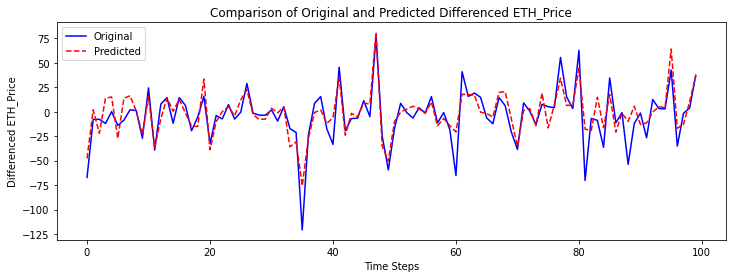

In [117]:
import matplotlib.pyplot as plt

# Reverse the normalization for predictions
mean_diff = scaler.mean_[df_diff.columns.get_loc('ETH_Price')]
std_diff = scaler.scale_[df_diff.columns.get_loc('ETH_Price')]
predictions_original_scale = [p * std_diff + mean_diff for p in predictionsLasso]

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Original Differenced ETH_Price': original_values,
    'Predicted Differenced ETH_Price': predictions_original_scale
})

# Print the comparison DataFrame
print(comparison_df)

# Plotting the comparison
plt.figure(figsize=(12, 4))
plt.plot(comparison_df['Original Differenced ETH_Price'], label='Original', color='blue')
plt.plot(comparison_df['Predicted Differenced ETH_Price'], label='Predicted', color='red', linestyle='--')
plt.title('Comparison of Original and Predicted Differenced ETH_Price')
plt.xlabel('Time Steps')
plt.ylabel('Differenced ETH_Price')
plt.legend()
plt.show()


In [111]:
from sklearn.linear_model import LinearRegression

# Initialize lists to store predictions and coefficients
ols_predictions = []
ols_coefficients = []
n = len(df_normalized)
start = n - 100
# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    
    # Define and fit the OLS model
    ols_model = LinearRegression()
    ols_model.fit(X_train, y_train)
    
    # Save coefficients
    ols_coefficients.append(ols_model.coef_)
    
    # Make prediction
    y_pred_ols = ols_model.predict(X[i].reshape(1, -1))
    ols_predictions.append(y_pred_ols[0])

# Calculate RMSE for OLS predictions
ols_rmse = np.sqrt(mean_squared_error(Y[start:], ols_predictions))
print(f"OLS RMSE: {ols_rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, ols_predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsOLS_array = np.array(ols_predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsOLS_array[1:] - predictionsOLS_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert OLS coefficients to a DataFrame for better visualization
ols_coef_df = pd.DataFrame(ols_coefficients, columns=df_lagged.columns)
print(ols_coef_df)


OLS RMSE: 0.18329263716238658
MAE: 0.13801364543351136
MDA: 68.68686868686868%


ValueError: 496 columns passed, passed data had 62 columns

In [85]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.tsa.stattools import adfuller
from scipy.stats import t
from statsmodels.api import OLS, add_constant

# Assuming 'actuals', 'predictionsLasso', and 'ols_predictions' are already defined

# Calculate squared forecast errors
squared_errors_lasso = (actuals - predictionsLasso) ** 2
squared_errors_ols = (actuals - ols_predictions) ** 2

# Compute differences in squared errors
error_diffs = squared_errors_lasso - squared_errors_ols

# Check for autocorrelation in error differences
stat, p_value_autocorr = acorr_ljungbox(error_diffs, lags=[1], return_df=True)
print(f"Ljung-Box test statistic: {stat}, p-value: {p_value_autocorr}")

# Check for stationarity
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs)
print(f"ADF test statistic: {adf_stat}, p-value: {adf_p_value}")

# Check for homoscedasticity (constant variance)
bp_test = het_breuschpagan(error_diffs, add_constant(actuals))
labels = ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

# Diebold-Mariano test
n = len(error_diffs)
mean_diff = np.mean(error_diffs)
std_diff = np.sqrt(np.var(error_diffs, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))

print(f"Diebold-Mariano test statistic: {DM_stat}, p-value: {p_value}")


Ljung-Box test statistic: [0.30196615], p-value: [0.58265244]
ADF test statistic: -0.9484721858435213, p-value: 0.7715912371715594
{'Lagrange Multiplier Statistic': 0.4228111726918504, 'p-value': 0.5155376464351489, 'f-value': 0.41611432710417884, 'f p-value': 0.5203896255328597}
Diebold-Mariano test statistic: -3.983887045421163, p-value: 0.0001296153137371192


/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [87]:
from statsmodels.tsa.stattools import adfuller, kpss
kpss_stat, kpss_p_value, _, _ = kpss(error_diffs, regression='c')
print(f"KPSS test statistic: {kpss_stat}, p-value: {kpss_p_value}")


KPSS test statistic: 0.5000184286680285, p-value: 0.04166251606575935


/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [108]:
#doing. and ar(1), ar(7)
from statsmodels.tsa.ar_model import AutoReg

# Your Y and start are already defined from the Lasso part
# Recursive window prediction for AR model, straight up with 7 lags
start = n - 100

ar_predictions = []

for i in range(start, n):
    # Define the training data up to point i
    y_train_ar = Y[:i]
    
    # Fit the AR model - we'll use a fixed lag of 7, you might have to adjust based on your previous criteria
    ar_model = AutoReg(y_train_ar, lags=1, old_names=False).fit()
    
    # Make the one-step-ahead forecast
    y_pred_ar = ar_model.predict(start=i, end=i)
    ar_predictions.append(y_pred_ar[0])

# Calculate RMSE for the AR predictions
ar_rmse = np.sqrt(mean_squared_error(Y[start:], ar_predictions))
print(f"AR Model RMSE for the last 100 values: {ar_rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, ar_predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsOLS_array = np.array(ar_predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsOLS_array[1:] - predictionsOLS_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

AR Model RMSE for the last 100 values: 0.2758212041945253
MAE: 0.18753542520133146
MDA: 67.67676767676768%


In [112]:
# Calculating squared forecast errors for AR(1) model
squared_errors_ar = (actuals - np.array(ar_predictions)) ** 2

# Compute differences in squared errors
error_diffs_lasso_ar = squared_errors_lasso - squared_errors_ar


# Check for autocorrelation, stationarity, and homoscedasticity for Lasso vs. AR(1)
print("Lasso vs AR(1):")
stat, p_value_autocorr = acorr_ljungbox(error_diffs_lasso_ar, lags=[1])
print(f"Ljung-Box test: {stat}, p-value: {p_value_autocorr}")
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs_lasso_ar)
print(f"ADF test: {adf_stat}, p-value: {adf_p_value}")
bp_test = het_breuschpagan(error_diffs_lasso_ar, add_constant(actuals))
print("Breusch-Pagan test:", dict(zip(labels, bp_test)))


# Diebold-Mariano test for Lasso vs. AR(1)
n = len(error_diffs_lasso_ar)
mean_diff = np.mean(error_diffs_lasso_ar)
std_diff = np.sqrt(np.var(error_diffs_lasso_ar, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))
print("\nDiebold-Mariano test (Lasso vs. AR(1)): DM_stat =", DM_stat, ", p-value =", p_value)



Lasso vs AR(1):
Ljung-Box test: [0.18503933], p-value: [0.66707781]
ADF test: -9.559619807948224, p-value: 2.445771280961824e-16
Breusch-Pagan test: {'Lagrange Multiplier Statistic': 14.990609210005967, 'p-value': 0.00010804752388729421, 'f-value': 17.281381373615275, 'f p-value': 6.907090797589333e-05}

Diebold-Mariano test (Lasso vs. AR(1)): DM_stat = -3.432815960981017 , p-value = 0.0008733784716514759


/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


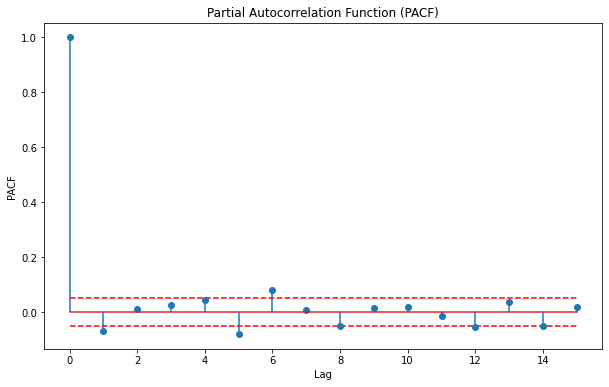

In [96]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming y_train_ar is your training data
lags = 15  # You can adjust the number of lags you want to inspect
pacf_values = sm.tsa.stattools.pacf(y_train_ar, nlags=lags)

# Plotting the PACF
plt.figure(figsize=(10, 6))
plt.stem(range(len(pacf_values)), pacf_values, use_line_collection=True)
plt.hlines([0.05, -0.05], xmin=0, xmax=lags, colors='r', linestyles='dashed')  # Significance lines
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()


In [113]:
# Assuming 'actuals', 'predictionsLasso', 'ols_predictions', and 'ar_predictions' are defined
#testing MAE for LASSO vs. OLS
# Calculate absolute errors
abs_errors_lasso = np.abs(actuals - predictionsLasso)
abs_errors_ols = np.abs(actuals - ols_predictions)
abs_errors_ar = np.abs(actuals - ar_predictions)

# Compute differences in absolute errors
error_diffs_mae_lasso_ols = abs_errors_lasso - abs_errors_ols
error_diffs_mae_lasso_ar = abs_errors_lasso - abs_errors_ar

# Check for autocorrelation in error differences (Lasso vs OLS)
print("Lasso vs OLS:")
stat, p_value_autocorr = acorr_ljungbox(error_diffs_mae_lasso_ols, lags=[1])
print(f"Ljung-Box test: {stat}, p-value: {p_value_autocorr}")

# Check for stationarity (Lasso vs OLS)
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs_mae_lasso_ols)
print(f"ADF test: {adf_stat}, p-value: {adf_p_value}")

# Check for homoscedasticity (Lasso vs OLS)
bp_test = het_breuschpagan(error_diffs_mae_lasso_ols, add_constant(actuals))
labels = ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:", dict(zip(labels, bp_test)))

# Diebold-Mariano test for MAE (Lasso vs OLS)
n = len(error_diffs_mae_lasso_ols)
mean_diff = np.mean(error_diffs_mae_lasso_ols)
std_diff = np.sqrt(np.var(error_diffs_mae_lasso_ols, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))
print("\nDiebold-Mariano test (Lasso vs OLS): DM_stat =", DM_stat, ", p-value =", p_value)

# Repeat the same steps for Lasso vs AR by replacing 'error_diffs_mae_lasso_ols' with 'error_diffs_mae_lasso_ar'

# Check for autocorrelation in error differences (Lasso vs AR)
print("Lasso vs AR:")
stat, p_value_autocorr = acorr_ljungbox(error_diffs_mae_lasso_ar, lags=[1])
print(f"Ljung-Box test: {stat}, p-value: {p_value_autocorr}")

# Check for stationarity (Lasso vs OLS)
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs_mae_lasso_ar)
print(f"ADF test: {adf_stat}, p-value: {adf_p_value}")

# Check for homoscedasticity (Lasso vs AR)
bp_test = het_breuschpagan(error_diffs_mae_lasso_ar, add_constant(actuals))
labels = ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:", dict(zip(labels, bp_test)))

# Diebold-Mariano test for MAE (Lasso vs AR)
n = len(error_diffs_mae_lasso_ar)
mean_diff = np.mean(error_diffs_mae_lasso_ar)
std_diff = np.sqrt(np.var(error_diffs_mae_lasso_ar, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))
print("\nDiebold-Mariano test (Lasso vs AR): DM_stat =", DM_stat, ", p-value =", p_value)


Lasso vs OLS:
Ljung-Box test: [0.05200304], p-value: [0.81961378]
ADF test: -9.718877421968736, p-value: 9.663332676984804e-17
Breusch-Pagan test: {'Lagrange Multiplier Statistic': 0.5702947605286446, 'p-value': 0.45014181017870203, 'f-value': 0.5620944605759601, 'f p-value': 0.4552136316293648}

Diebold-Mariano test (Lasso vs OLS): DM_stat = -5.256677888393683 , p-value = 8.457888580615247e-07
Lasso vs AR:
Ljung-Box test: [0.63082749], p-value: [0.42705195]
ADF test: -9.12812795578285, p-value: 3.0738271188795807e-15
Breusch-Pagan test: {'Lagrange Multiplier Statistic': 3.2668070354641032, 'p-value': 0.0706950947921416, 'f-value': 3.3095887736575973, 'f p-value': 0.0719302774355518}

Diebold-Mariano test (Lasso vs AR): DM_stat = -4.921851745574337 , p-value = 3.4242156952135616e-06


/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
